### Backpropogation in detail!

First few cells remain the same

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt

--2023-05-30 22:18:21--  https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2023-05-30 22:18:21 (8.22 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt').read().splitlines()
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
# Build vocab of characters and mapping to and from integers
chars = sorted(list(set(''.join(words))))
assert len(chars) == 26

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

print(stoi)
print(itos)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
import random

block_size = 3

def build_dataset(words):
  
  X, Y = [], []

  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

# Random shuffle of words
random.seed(42)
random.shuffle(words)
# Training data -> 80%, Val data -> 10%, testing data -> 10%
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

print('Training Data Size: ', len(X_train))
print('Validation Data Size: ', len(X_val))
print('Testing Data Size: ', len(X_test))

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
Training Data Size:  182625
Validation Data Size:  22655
Testing Data Size:  22866


In [7]:
def cmp(s, dt, t):
  '''
  Utility function to compare manual gradients to pytorch gradients
  '''

  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for demo, it's useless because of BatchNorm
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

Notice the initialization of some params doesn't match what we did previously. This is to avoid cases when an incorrect implementation is ignored, just becuase all the outputs were zero

In [9]:
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [10]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

### Forward Pass

Explanation for calculation of bnvar and bnraw - 


1. bnvar: Variance is defined as - 

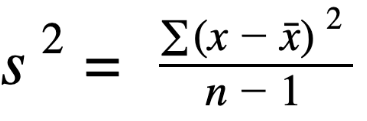

* Step 1 - Calculate mean (bnmeani)
* Step 2 - Calculate diff (bndiff)
* Step 3 - Calculate diff squared (bndiff2)
* Step 4a - Calculate sum across axis=0, since we want the sum of the entire attribute. Think of it like this, we have 32 examples and 64 attributes. We are summing up individual attributes for all the examples, hence the output converts to [1, 64]. Also, it helps to know that pytorch collapses the axis provided as input to 1, i.e, the sum is done across that axis
* Step 4b - Divide the sum by 1/(n-1). This gives the variance of layer 1

Next, use the variance to get batchNorm. Referring [BatchNorm Paper](https://arxiv.org/pdf/1502.03167.pdf), and following the algorithm below - 

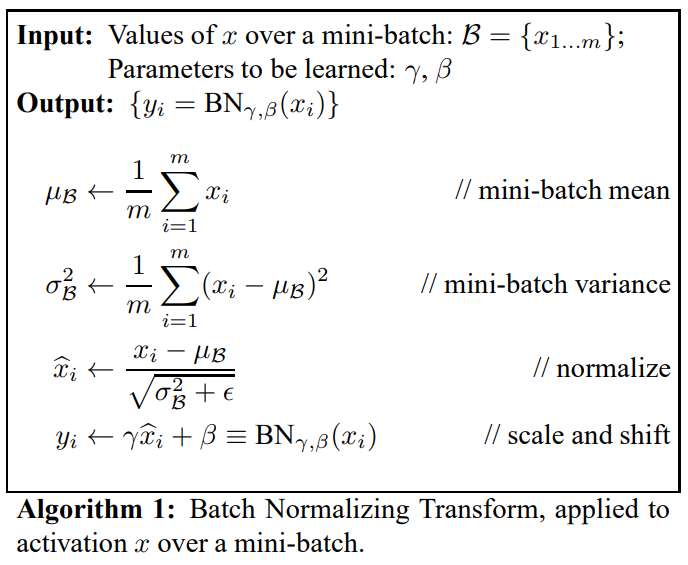

we've calculated sigma-squared. 

* Step 6 - Now, adding a small number (to avoid ZeroDivError), get the denominator of normalization. 

* Step 7 - Multiplying by diff calculated in step 2 (since we already inverse-squared the denominator), we get the normalization value for the tensor

* Step 8 - Next, apply Scale and Shift to the normalization value

In [11]:
# Convert inputs to embeddings and reshape
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# Layer 1 - Hidden layer pre-activation (and pre-batchNorm)
hprebn = embcat @ W1 + b1
# BatchNorm Layer
# Logic below calculates BN using basic ops
bnmeani = 1/n*hprebn.sum(axis=0, keepdim=True) # Using instead of built-in mean()
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(n-1) * bndiff2.sum(axis=0, keepdim=True)  # Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
# Hidder pre-activation
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)

# Layer 2
logits = h @ W2 + b2

#### Calculate Loss

Cross Entropy Loss implementation - same as F.cross_entropy()


**NOTE-** BUG FIX BELOW - UPDATE SUM AXIS TO 1 FOR COUNTS_SUM AND LOGIT_MAXES

In [12]:
logit_maxes = logits.max(axis=1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability

counts = norm_logits.exp()
counts_sum = counts.sum(axis=1, keepdim=True)
counts_sum_inv = counts_sum**-1

probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#### Pytorch Backward Pass

In [13]:
for p in parameters:
  p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
  t.retain_grad()

loss.backward()
loss

tensor(3.3415, grad_fn=<NegBackward0>)

#### Manual Backprop
This is where the fun starts!

>Notation - dlogprobs is defined as d(loss) / d(logprobs). Similarly, dprobs is defined as d(loss) / d(probs) and so on to keep the notation in check. The idea is go backwards in the computation graph from loss, trace back computation and calculating gradient at every step. Remember from [Autograd Notebook](https://github.com/suvigyajain0101/NLP/blob/738d0446b0e1cb90f59c56f03e2bae9fd38ea85e/Autograd/micrograd.ipynb), the derivative at a node is the product of local derivative and the global derivative at the node (proven using chain rule)


so, dlogprobs, when loss = -logprobs[range(n), Yb].mean() - this can be thought of dy/dx when y = x/n, since .mean() signifies that some values are being added and divided by the number of terms (which is n here). Hence the derivative should be -1/n



In [14]:
# dlogprobs is short for d (loss) / d (logprobs). 
# Since loss is the mean of indexed values from logprobs, dloss wrt to logprobs would be -1/no. of terms in logprobs
dlogprobs = torch.zeros_like(logprobs) # we expect the shape to exactly match
dlogprobs[range(n), Yb] = -1.0/n

cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


dprobs (or d(logprobs)/d(probs)) when logprobs = probs.log() is simply

  &emsp;&emsp;&emsp;&emsp;$d(loss) \over d(probs)$ = $d(loss) \over d(logprobs)$ * $d(logprobs) \over d(probs)$

We already first team of RHS calculated before (dlogprobs). Second term is simply 1/probs (since d log(y) / dx = 1/y * dy/dx)

In [15]:
dprobs = (1.0 / probs) * dlogprobs # d log(y) / dx = 1/y * dy/dx
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


dcounts_sum_inv is defined as d(Loss) / d(counts_sum_inv), which can be broken using probs by chain rule.

&emsp;&emsp;&emsp;&emsp;$d(loss) \over d(counts-sum-inv)$ = $d(loss) \over d(probs)$ * $d(probs) \over d(counts-sum-inv)$

We've already calculated 1st term of RHS, second comes from the equation - 

&emsp;&emsp;&emsp;&emsp;probs = counts * counts_sum_inv, 

which is equal to counts (since, d(cx)/d(x) = c if c is a constant)

But the important thing to note is the shapes of both the matrices used to create probs

In [16]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

Actually, there are 2 operations happening here - multiplication and broadcasting. The tensor counts_sum_inv is being broadcasted 27 times to the tensor counts, and to correctly calculate the derivative, we need to sum across the rows. This also makes sure that the tensor and it's gradient have the same shape

In [17]:
# probs = counts * counts_sum_inv
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


For dcounts, we don't need to sum across rows, since both the tensor and its gradient have the same shape.

But we won't be able to compare the manual gradient with pytorch gradient just yet, since counts also depends on counts_sum_inv

In [18]:
dcounts = counts_sum_inv * dprobs

dcounts_sum can be simply written as d(1/x)/dx = -1/x**2 and then multiplied by global derivative

In [19]:
dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


Next, we need to backpropogate through this line ->

counts_sum = counts.sum(axis=1, keepdim=True)

In [20]:
counts.shape, counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

We need to take the column of derivatives of counts_sum to a matrix (counts)
Also, remember, we already calculated dcounts earlier. The new gradient needs to be added to previous calculation. We can think of this as gradient coming from multiple branches and it gets summed at the final node

To do this, we can create an array using shape like and pass the gradient to replicate along the desired output shape. Now since the original operation is just sum across axis, it's derivative is 1. So, we can use ones_like

In [21]:
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


Next is norm_logits (counts is element wise exp of norm logits). d(e^x)/dx = e^x

In [23]:
dnorm_logits = (norm_logits.exp()) * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


Another way to write this is if we replace the first term directly by counts

In [24]:
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


This works as well!

Next is the line -> norm_logits = logits - logit_maxes

Here again, shapes are not the same and their is an implicit broadcasting

In [25]:
logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

dlogits is also calculated from a second branch (since, logit_maxes depends on logits -> 

logit_maxes = logits.max(axis=1, keepdim=True).values)

In [ ]:
dlogits = torch.ones_like(logits) * dnorm_logits

But dlogit_maxes is only the single branch

In [33]:
dlogit_maxes = (-dnorm_logits).sum(1,keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logits          | exact: True  | approximate: True  | maxdiff: 0.0
